
###  **Project: Predictive Maintenance for Wind Turbines**

---

#### **Problem Statement**

You are tasked with designing a machine learning-based predictive maintenance system for wind turbines on behalf of a customer. The objective is to build a system that:

* Predicts **all failure events** as early as possible,
*  Minimizes the **false alarm rate** to avoid unnecessary maintenance.

We focus on **Wind Farm C**, as described in the dataset accompanying \[1].

---

####  **Work Package 1 – Data Analysis and Feature Selection**

We use one year of SCADA data from Wind Farm C, containing 10-minute-interval readings from 238 sensors, totaling **52,560 samples**. Each sensor is represented with statistical aggregates such as mean, standard deviation, min, and max, leading to **957 features**.

To prepare high-quality input for ML models:

* ✅ **Operational status filtering**: We include only status types corresponding to normal operation (status\_type\_id 0 or 2).
* ✅ **Noise removal**: DBSCAN clustering is used to eliminate outliers in wind-power space.
* ✅ **Ideal power curve fitting**: A polynomial power curve with ±3σ bounds ensures only realistic, healthy operational data is retained.
* ✅ **Correlation-based feature filtering**: Highly correlated sensor features are reduced using domain-prioritized ranking.
* ✅ **Low-variance & redundant feature elimination**: Features with low variability or mostly zero values are dropped.

> ⚙️ Final feature set includes power, temperature, generator, gearbox, and vibration features — selected for their relevance to fault dynamics.

---

####  **Work Package 2 – Modeling and Evaluation**

We implement and compare two strategies:

---

### 1️⃣ **Unsupervised Approach – KMeans Clustering**

* **Training**: Only on normal operational data.
* **Anomaly scoring**: Based on distance to the learned cluster centroid.
* **Detection**: A 99th percentile threshold is applied to smoothed anomaly scores.
* **Lead time achieved**:  **3 days **
* **False alarm rate**:  **1.07%**
* **Performance**:

  * Accuracy: **95%**
  * Precision (fault): High
  * Recall (fault): Strong early detection

---

### 2️⃣ **Supervised Approach – XGBoost Classifier**

* **Labeling**:

  * Pre-failure window (last 24h) → Anomalous (1)
  * Others → Normal (0)
* **Data balancing**: 10,000 normal samples + all anomaly samples
* **Model config**: 100 rounds, depth=5, learning rate=0.1, `scale_pos_weight` adjusted
* **Lead time achieved**: **22 hours 40 minutes**
* **False alarm rate on healthy data**:  **0.00%**
* **Performance metrics**:

  * Accuracy: **96.1%**
  * F1-Score (anomaly): **0.868**
  * Confusion matrix: Very low FN and FP rates

---

####  **Figures and Visualizations**

* Anomaly timelines for each approach
* Histogram of anomaly scores
* Confusion matrices
* DBSCAN cleaning before/after
* Power curve with ±3σ bounds

---

####  **Conclusion**

Both methods successfully meet the customer’s requirements of **early detection** and **low false alarm rate**:

| Approach | Lead Time | Accuracy | False Alarm Rate | F1 (Anomaly) | Notes                      |
| -------- | --------- | -------- | ---------------- | ------------ | -------------------------- |
| KMeans   | 3d    | 95%      | 1.07%            | High         | Needs only normal data     |
| XGBoost  | 22h 40min | 96.1%    | 0.00%            | 0.868        | Requires labeled anomalies |


In [1]:
import pandas as pd

# Load SCADA and event inf¯o data
scada_df = pd.read_csv('datasets/47.csv',sep = ";", parse_dates=['time_stamp'])
event_df = pd.read_csv('/home/bcae/ML_Cleaned_with_sensors/event_info.csv',sep = ";", parse_dates=['event_start', 'event_end'])



/tmp/ipykernel_1417293/3695982794.py:5: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  event_df = pd.read_csv('/home/bcae/ML_Cleaned_with_sensors/event_info.csv',sep = ";", parse_dates=['event_start', 'event_end'])
/tmp/ipykernel_1417293/3695982794.py:5: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  event_df = pd.read_csv('/home/bcae/ML_Cleaned_with_sensors/event_info.csv',sep = ";", parse_dates=['event_start', 'event_end'])


In [2]:
scada_df.head()

,time_stamp,asset_id,id,train_test,status_type_id,sensor_0_avg,sensor_0_max,sensor_0_min,sensor_0_std,sensor_1_avg,...,wind_speed_236_min,wind_speed_236_std,wind_speed_235_avg,wind_speed_235_max,wind_speed_235_min,wind_speed_235_std,wind_speed_237_avg,wind_speed_237_max,wind_speed_237_min,wind_speed_237_std
0,2022-12-22 15:00:00,21,0,train,0,8.794,15.9,3.9,2.157,-0.0255,...,1.65,0.9097,5.129,8.4,2.1,0.9977,5.132,8.6,0.6,1.079
1,2022-12-22 15:10:00,21,1,train,0,10.035,14.0,5.5,1.876,0.0196,...,2.60,0.9640,5.403,8.7,1.8,1.0870,5.359,9.3,1.0,1.080
2,2022-12-22 15:20:00,21,2,train,0,12.419,18.8,6.8,2.282,-0.0015,...,2.55,0.8070,5.510,9.0,1.8,0.9002,5.611,8.8,0.8,1.067
3,2022-12-22 15:30:00,21,3,train,0,12.512,16.2,7.8,1.445,0.0095,...,2.45,0.8639,5.640,9.3,2.4,0.9638,5.650,9.1,1.3,1.031
4,2022-12-22 15:40:00,21,4,train,0,13.386,17.5,9.4,1.666,0.0025,...,3.30,0.8259,5.582,9.0,1.6,0.9208,5.892,9.9,2.2,1.014


In [3]:


# Split into train and test BEFORE filtering
df_train = scada_df[scada_df['train_test'] == 'train'].copy()
df_test = scada_df[scada_df['train_test'] == 'prediction'].copy()

# Filter only the train set for healthy samples
df_train = df_train[df_train['status_type_id'] == 0].copy()
# (df_test_raw remains untouched for labeling faults later)


In [4]:
import numpy as np

# Copy test data for labeling
df_test_labeled = df_test.copy()
df_test_labeled['label'] = 'normal'  # default

# Loop through each fault event and label the matching time range
for idx, row in event_df.iterrows():
    asset_id = row['asset_id']
    start_ts = row['event_start']
    end_ts = row['event_end']
    fault_label = row['event_label'].lower().replace(' ', '_')  # standardize

    # Identify matching rows in test data
    condition = (
        (df_test_labeled['asset_id'] == asset_id) &
        (df_test_labeled['time_stamp'] >= start_ts) &
        (df_test_labeled['time_stamp'] <= end_ts)
    )

    df_test_labeled.loc[condition, 'label'] = fault_label

# Summary of labels
print(df_test_labeled['label'].value_counts())


label
normal     864
anomaly    713
Name: count, dtype: int64


In [5]:
df_selected = df_train.dropna()
df_selected = df_selected[['time_stamp', 'wind_speed_236_avg', 'power_2_avg']]
df_selected.columns = ['time', 'wind_speed', 'power']  # 
df_selected = df_selected[(df_selected['wind_speed'] > 0) & (df_selected['power'] > 0.01)]


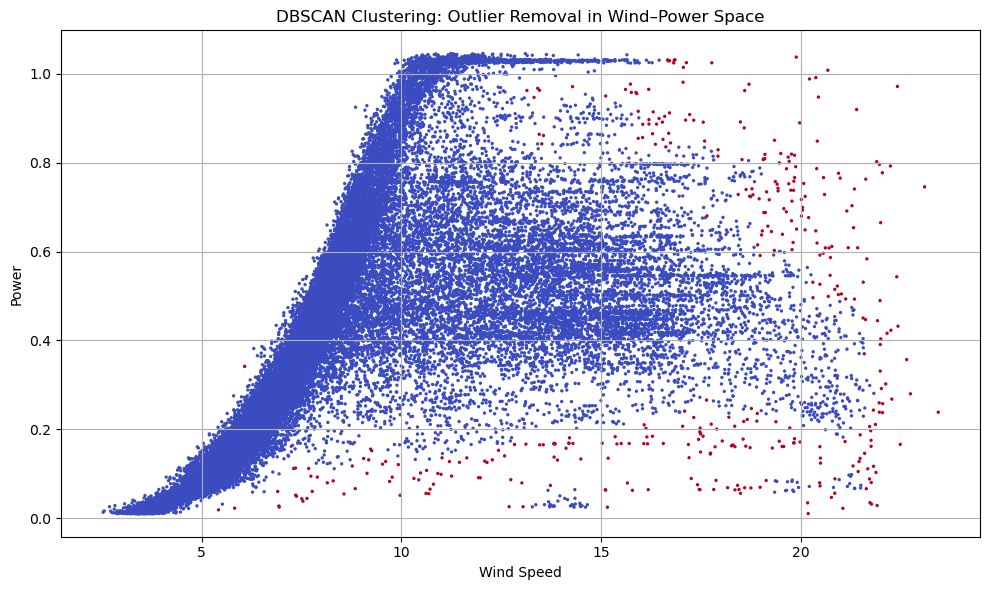

Cleaned data shape: (41020, 4)


In [6]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Use only wind_speed and power
df_dbscan = df_selected[['wind_speed', 'power']].copy()

# Normalize features for DBSCAN (important for Euclidean distance-based clustering)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_dbscan)

# Apply DBSCAN
db = DBSCAN(eps=0.1, min_samples=10)
labels = db.fit_predict(data_scaled)

# Add cluster labels to df_selected (NOT df_dbscan, to preserve full original context)
df_selected['dbscan_label'] = labels

# Filter out noise points (label = -1)
df_cleaned = df_selected[df_selected['dbscan_label'] != -1].copy()

# Visualize: noise = red (label -1), others = blue
plt.figure(figsize=(10, 6))
plt.scatter(df_selected['wind_speed'], df_selected['power'], 
            c=(df_selected['dbscan_label'] == -1), cmap='coolwarm', s=2)
plt.xlabel("Wind Speed")
plt.ylabel("Power")
plt.title("DBSCAN Clustering: Outlier Removal in Wind–Power Space")
plt.grid(True)
plt.tight_layout()
plt.show()

# Display cleaned data size
print("Cleaned data shape:", df_cleaned.shape)


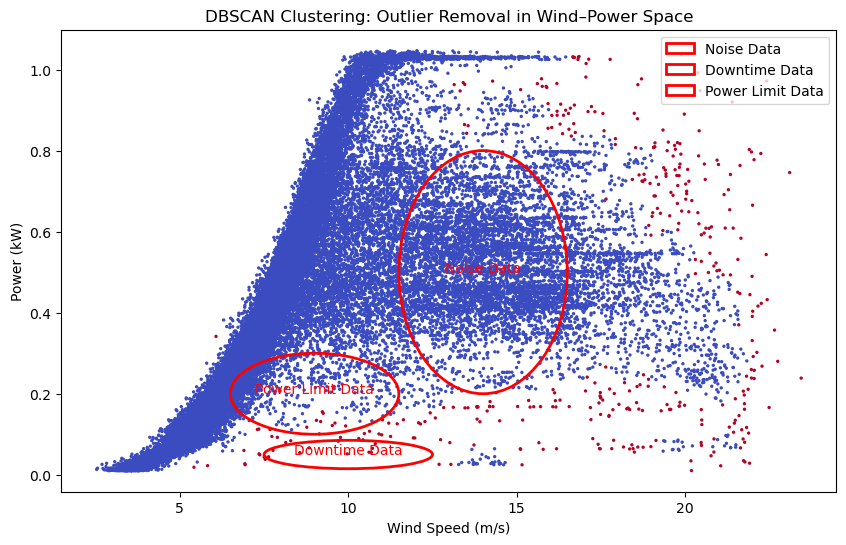

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot all data, coloring noise points red
ax.scatter(df_selected['wind_speed'], df_selected['power'], 
           c=(df_selected['dbscan_label'] == -1), cmap='coolwarm', s=2)

# Add ellipses manually (same as before)
from matplotlib.patches import Ellipse

noise_ellipse = Ellipse(xy=(14, 0.5), width=5, height=0.6, edgecolor='red', fc='None', lw=2, label='Noise Data')
downtime_ellipse = Ellipse(xy=(10, 0.05), width=5, height=0.07, edgecolor='red', fc='None', lw=2, label='Downtime Data')
limit_ellipse = Ellipse(xy=(9, 0.2), width=5, height=0.2, edgecolor='red', fc='None', lw=2, label='Power Limit Data')

for ellipse, label in zip([noise_ellipse, downtime_ellipse, limit_ellipse],
                          ['Noise Data', 'Downtime Data', 'Power Limit Data']):
    ax.add_patch(ellipse)
    ax.text(ellipse.center[0], ellipse.center[1], label, color='red', fontsize=10, ha='center')

ax.set_title("DBSCAN Clustering: Outlier Removal in Wind–Power Space")
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Power (kW)")
ax.legend(loc='upper right')
plt.show()


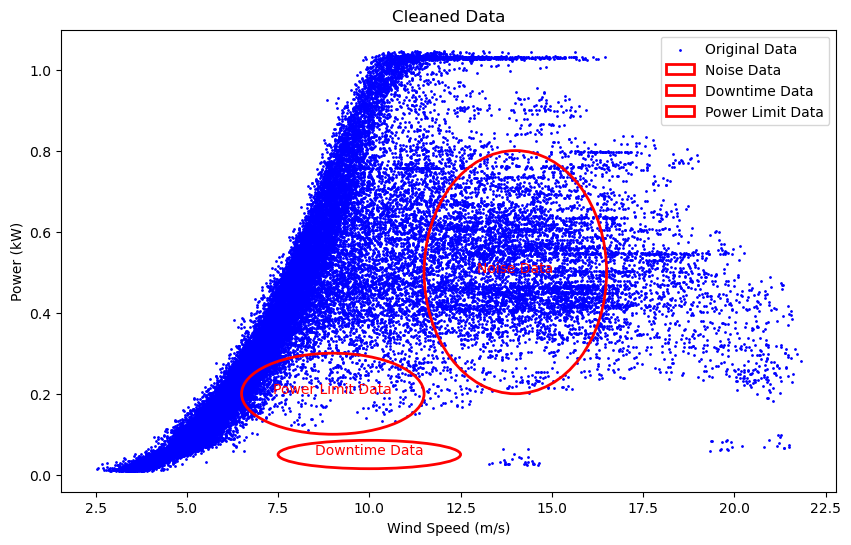

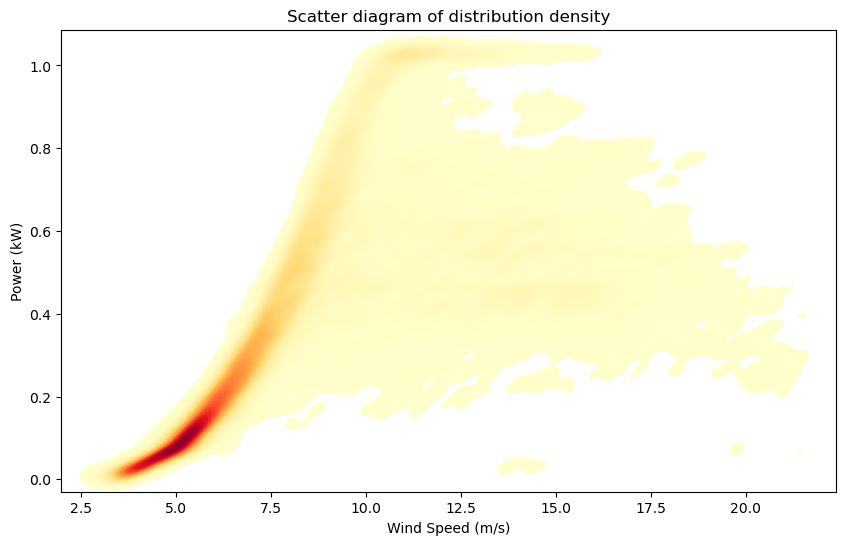

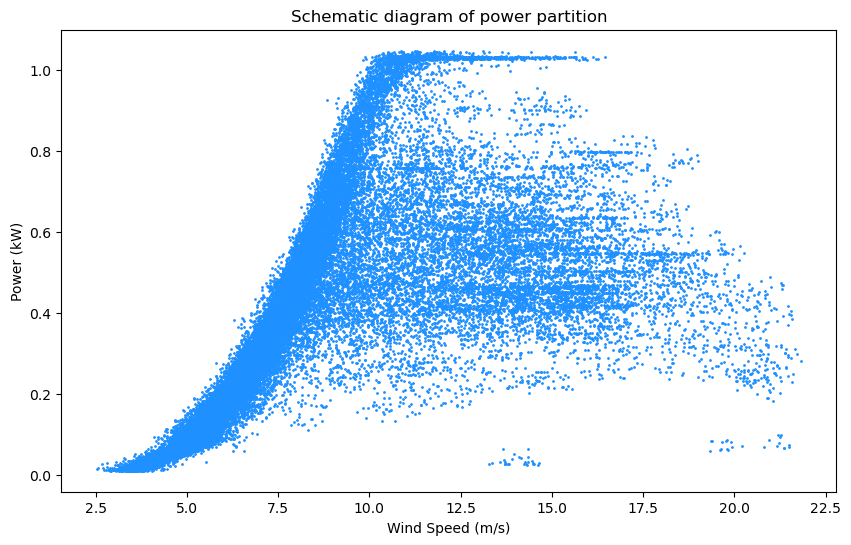

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# df_cleaned contains columns: wind_speed, power

# Step 1: (a) Scatter plot with highlighted abnormal regions
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df_cleaned['wind_speed'], df_cleaned['power'], s=1, c='blue', label='Original Data')

# Add ellipses manually to approximate paper's style
from matplotlib.patches import Ellipse

noise_ellipse = Ellipse(xy=(14, 0.5), width=5, height=0.6, edgecolor='red', fc='None', lw=2, label='Noise Data')
downtime_ellipse = Ellipse(xy=(10, 0.05), width=5, height=0.07, edgecolor='red', fc='None', lw=2, label='Downtime Data')
limit_ellipse = Ellipse(xy=(9, 0.2), width=5, height=0.2, edgecolor='red', fc='None', lw=2, label='Power Limit Data')

for ellipse, label in zip([noise_ellipse, downtime_ellipse, limit_ellipse],
                          ['Noise Data', 'Downtime Data', 'Power Limit Data']):
    ax.add_patch(ellipse)
    ax.text(ellipse.center[0], ellipse.center[1], label, color='red', fontsize=10, ha='center')

ax.set_title("Cleaned Data")
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Power (kW)")
ax.legend(loc='upper right')
plt.show()

# Step 2: (b) Density-based scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(
    x=df_cleaned['wind_speed'], 
    y=df_cleaned['power'], 
    cmap="YlOrRd", fill=True, bw_adjust=0.3, ax=ax, levels=100, thresh=0.01
)
ax.set_title("Scatter diagram of distribution density")
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Power (kW)")
plt.show()

# Step 3: Power partition visualization
bin_width = 0.05 # Power min/max: 0.010 → 1.046
df_cleaned['power_bin'] = (df_cleaned['power'] // bin_width) * bin_width

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df_cleaned['wind_speed'], df_cleaned['power'], s=1, c='dodgerblue')
ax.set_title("Schematic diagram of power partition")
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Power (kW)")
plt.show()


Number of points in downtime cluster region: 0
Percentage of downtime points in dataset: 0.00%


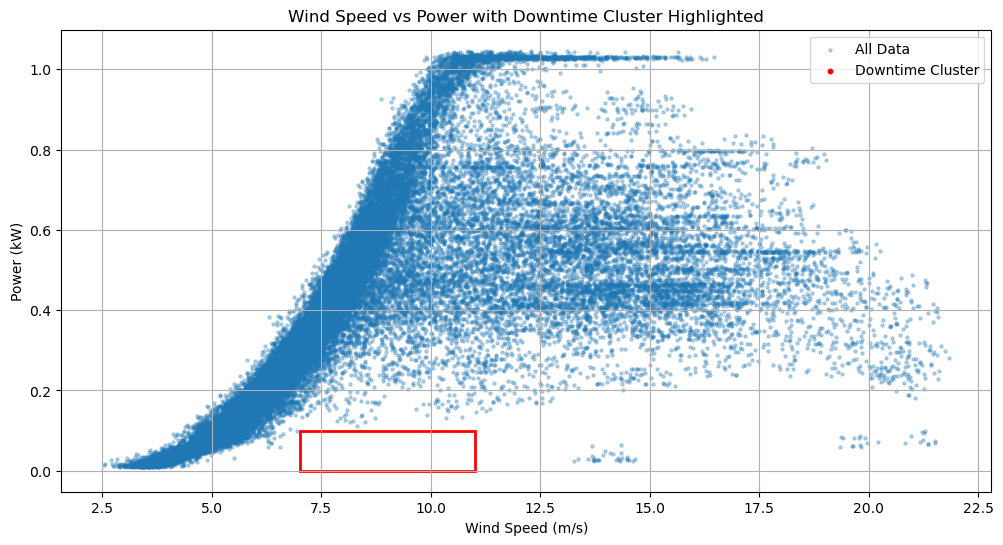

In [9]:
import matplotlib.patches as patches

# Define the downtime cluster boundary (approximate, adjust based on your plot)
downtime_x_min, downtime_x_max = 7, 11  # Wind Speed range (m/s)
downtime_y_min, downtime_y_max = 0, 0.1  # Power range (kW)

# Filter points in downtime region
downtime_points = df_cleaned[
    (df_cleaned['wind_speed'] >= downtime_x_min) & (df_cleaned['wind_speed'] <= downtime_x_max) &
    (df_cleaned['power'] >= downtime_y_min) & (df_cleaned['power'] <= downtime_y_max)
]

print(f"Number of points in downtime cluster region: {len(downtime_points)}")
print(f"Percentage of downtime points in dataset: {len(downtime_points)/len(df_cleaned)*100:.2f}%")

# Optional: plot again highlighting downtime points
plt.figure(figsize=(12, 6))
plt.scatter(df_cleaned['wind_speed'], df_cleaned['power'], s=5, label='All Data', alpha=0.3)
plt.scatter(downtime_points['wind_speed'], downtime_points['power'], color='red', s=10, label='Downtime Cluster')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.title('Wind Speed vs Power with Downtime Cluster Highlighted')
plt.legend()
plt.grid(True)

# Draw rectangle around downtime region for clarity
ax = plt.gca()
rect = patches.Rectangle((downtime_x_min, downtime_y_min), downtime_x_max - downtime_x_min, downtime_y_max - downtime_y_min, linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(rect)

plt.show()


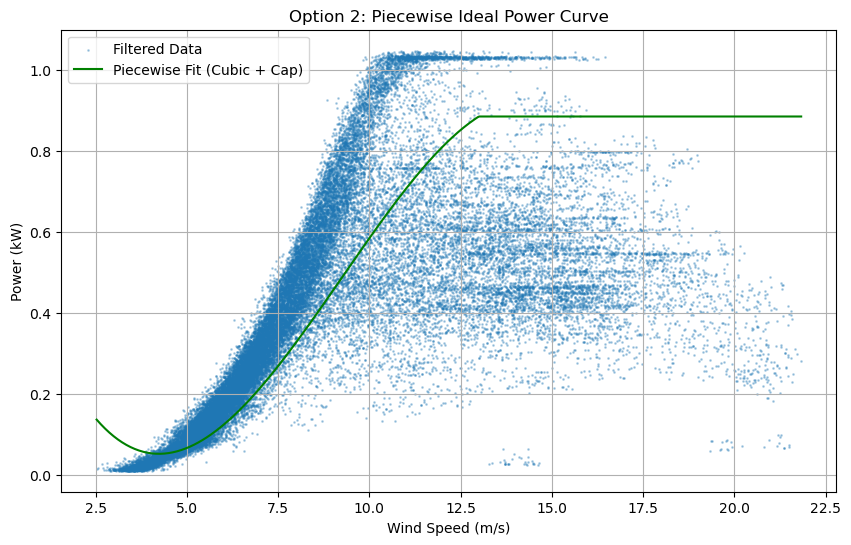

In [10]:
# Piecewise: Fit cubic up to 13 m/s, constant after

# Calculate midpoints
midpoints = df_cleaned.groupby('power_bin').agg({
    'wind_speed': ['mean', 'std'],
    'power': 'mean'
}).dropna().reset_index()

# Flatten column names
midpoints.columns = ['power_bin', 'wind_speed_mean', 'wind_speed_std', 'power_mean']

cutoff_speed = 13
mid_rising = midpoints[midpoints['wind_speed_mean'] <= cutoff_speed]

# Fit cubic to rising part
coeffs_opt2 = np.polyfit(mid_rising['wind_speed_mean'], mid_rising['power_mean'], deg=3)
poly_opt2 = np.poly1d(coeffs_opt2)

# Cap value = last point of the fitted rising curve
cap_value = poly_opt2(cutoff_speed)

# Generate piecewise function
wind_range = np.linspace(df_cleaned['wind_speed'].min(), df_cleaned['wind_speed'].max(), 500)
fitted_power_opt2 = np.piecewise(
    wind_range,
    [wind_range <= cutoff_speed, wind_range > cutoff_speed],
    [lambda x: poly_opt2(x), lambda x: cap_value]
)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_cleaned['wind_speed'], df_cleaned['power'], s=1, alpha=0.3, label='Filtered Data')
plt.plot(wind_range, fitted_power_opt2, color='green', label='Piecewise Fit (Cubic + Cap)')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.title('Option 2: Piecewise Ideal Power Curve')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# Average standard deviation from power-bin midpoints
sigma = midpoints['wind_speed_std'].mean()

# Predict ideal power using Option 2’s piecewise function
def piecewise_ideal(x):
    return np.where(x <= cutoff_speed, poly_opt2(x), cap_value)

df_cleaned['ideal_power'] = piecewise_ideal(df_cleaned['wind_speed'])

# Compute upper/lower bounds using 3-sigma rule
df_cleaned['ideal_upper'] = piecewise_ideal(df_cleaned['wind_speed'] + 3 * sigma)
df_cleaned['ideal_lower'] = piecewise_ideal(df_cleaned['wind_speed'] - 3 * sigma)

# Filter points within normal band
condition = (
    (df_cleaned['power'] >= df_cleaned['ideal_lower']) &
    (df_cleaned['power'] <= df_cleaned['ideal_upper'])
)

df_final_health = df_cleaned[condition].copy()
print("Final cleaned (3σ filtered) sample count:", df_final_health.shape[0])


Final cleaned (3σ filtered) sample count: 17734


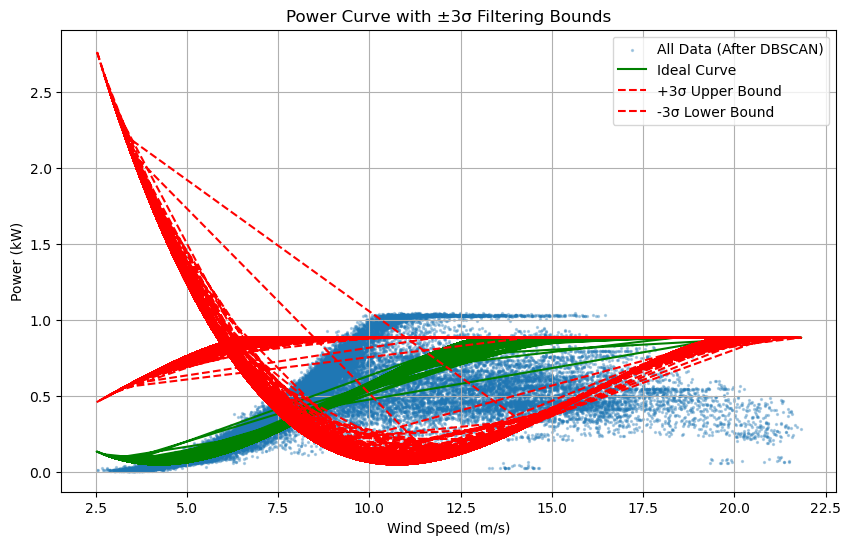

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df_cleaned['wind_speed'], df_cleaned['power'], s=2, alpha=0.3, label='All Data (After DBSCAN)')
plt.plot(df_cleaned['wind_speed'], df_cleaned['ideal_power'], color='green', label='Ideal Curve')
plt.plot(df_cleaned['wind_speed'], df_cleaned['ideal_upper'], color='red', linestyle='--', label='+3σ Upper Bound')
plt.plot(df_cleaned['wind_speed'], df_cleaned['ideal_lower'], color='red', linestyle='--', label='-3σ Lower Bound')
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Power (kW)")
plt.title("Power Curve with ±3σ Filtering Bounds")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# Get sigma in wind speed domain (same as before)
sigma = midpoints['wind_speed_std'].mean()

#  Predict ideal power once
df_cleaned['ideal_power'] = piecewise_ideal(df_cleaned['wind_speed'])

# Compute residuals between actual and ideal
df_cleaned['residual'] = df_cleaned['power'] - df_cleaned['ideal_power']

# Compute standard deviation of residuals (i.e., how power deviates from the curve)
residual_std = df_cleaned['residual'].std()

# Use that to define fixed upper/lower bounds around ideal_power
df_cleaned['ideal_upper'] = df_cleaned['ideal_power'] + 3 * residual_std
df_cleaned['ideal_lower'] = df_cleaned['ideal_power'] - 3 * residual_std

# Apply filtering
condition = (
    (df_cleaned['power'] >= df_cleaned['ideal_lower']) &
    (df_cleaned['power'] <= df_cleaned['ideal_upper'])
)

df_final_health = df_cleaned[condition].copy()
print("Final cleaned (residual-based 3σ) sample count:", df_final_health.shape[0])


Final cleaned (residual-based 3σ) sample count: 40803


In [14]:
df_final_health.shape

(40803, 9)

In [15]:
# Ensure timestamps are in datetime format
df_final_health['time'] = pd.to_datetime(df_final_health['time'])
df_train['timestamp'] = pd.to_datetime(df_train['time_stamp'])

# Merge on timestamp (and optionally asset_id if multiple turbines)
df_full_health = pd.merge(
    df_final_health[['time']],           # Only need time to join
    df_train,                        # Contains full features
    left_on='time',
    right_on='time_stamp',
    how='inner'                          # Only keep matching timestamps
)

# Drop duplicate or redundant columns
df_full_health = df_full_health.drop(columns=['time_stamp'])

# Reset index
df_full_health.reset_index(drop=True, inplace=True)

# Final shape
print("Full health dataset shape:", df_full_health.shape)
df_full_health.head()


Full health dataset shape: (40803, 958)


,time,asset_id,id,train_test,status_type_id,sensor_0_avg,sensor_0_max,sensor_0_min,sensor_0_std,sensor_1_avg,...,wind_speed_236_std,wind_speed_235_avg,wind_speed_235_max,wind_speed_235_min,wind_speed_235_std,wind_speed_237_avg,wind_speed_237_max,wind_speed_237_min,wind_speed_237_std,timestamp
0,2022-12-22 15:00:00,21,0,train,0,8.794,15.9,3.9,2.157,-0.0255,...,0.9097,5.129,8.4,2.1,0.9977,5.132,8.6,0.6,1.079,2022-12-22 15:00:00
1,2022-12-22 15:10:00,21,1,train,0,10.035,14.0,5.5,1.876,0.0196,...,0.9640,5.403,8.7,1.8,1.0870,5.359,9.3,1.0,1.080,2022-12-22 15:10:00
2,2022-12-22 15:20:00,21,2,train,0,12.419,18.8,6.8,2.282,-0.0015,...,0.8070,5.510,9.0,1.8,0.9002,5.611,8.8,0.8,1.067,2022-12-22 15:20:00
3,2022-12-22 15:30:00,21,3,train,0,12.512,16.2,7.8,1.445,0.0095,...,0.8639,5.640,9.3,2.4,0.9638,5.650,9.1,1.3,1.031,2022-12-22 15:30:00
4,2022-12-22 15:40:00,21,4,train,0,13.386,17.5,9.4,1.666,0.0025,...,0.8259,5.582,9.0,1.6,0.9208,5.892,9.9,2.2,1.014,2022-12-22 15:40:00


In [16]:

metadata_cols = ['time_stamp', 'asset_id','id','status_type_id', 'train_test']  # Adjust as needed
df_train_metadata = df_train[metadata_cols] if all(col in df_train.columns for col in metadata_cols) else pd.DataFrame()
df_test_metadata = df_test[metadata_cols] if all(col in df_test.columns for col in metadata_cols) else pd.DataFrame()

In [17]:
import pandas as pd

# Define metadata columns
metadata_cols = ['id','time_stamp', 'asset_id', 'status_type_id', 'train_test', 'label']

#  Separate sensor columns from df_full_health and df_test_labeled
sensor_cols_train = [col for col in df_full_health.columns if col not in metadata_cols]
sensor_cols_test = [col for col in df_test_labeled.columns if col not in metadata_cols]

#  Extract only sensor data for zero-percentage check
df_train_sensor_only = df_full_health[sensor_cols_train]

# Calculate percentage of zeros in training set
zero_pct_train = (df_train_sensor_only == 0).sum() / len(df_train_sensor_only) * 100

# Identify columns to drop (≥ 80% zero values)
cols_to_drop = zero_pct_train[zero_pct_train >= 80].index.tolist()

#Create reduced sensor+metadata DataFrames (keep metadata)
df_train_sensors_reduced = df_full_health.drop(columns=cols_to_drop)
df_test_sensors_reduced = df_test_labeled.drop(columns=[col for col in cols_to_drop if col in df_test_labeled.columns])

# df_train_sensors_reduced and df_test_sensors_reduced retain metadata
print("Train shape:", df_train_sensors_reduced.shape)
print("Test shape:", df_test_sensors_reduced.shape)


Train shape: (40803, 911)
Test shape: (1577, 911)


In [18]:
df_train_sensors_reduced['timestamp'].head()

0   2022-12-22 15:00:00
1   2022-12-22 15:10:00
2   2022-12-22 15:20:00
3   2022-12-22 15:30:00
4   2022-12-22 15:40:00
Name: timestamp, dtype: datetime64[ns]

In [19]:
df_test_labeled.head()

,time_stamp,asset_id,id,train_test,status_type_id,sensor_0_avg,sensor_0_max,sensor_0_min,sensor_0_std,sensor_1_avg,...,wind_speed_236_std,wind_speed_235_avg,wind_speed_235_max,wind_speed_235_min,wind_speed_235_std,wind_speed_237_avg,wind_speed_237_max,wind_speed_237_min,wind_speed_237_std,label
52416,2023-12-22 15:00:00,21,52416,prediction,0,75.494,90.7,62.1,6.609,-0.0004,...,0.9677,9.593,13.0,5.4,1.1290,9.861,13.9,5.1,1.220,anomaly
52417,2023-12-22 15:10:00,21,52417,prediction,0,67.623,80.9,54.6,5.620,0.0004,...,0.9077,9.146,11.9,5.5,0.9794,9.610,13.0,4.6,1.187,anomaly
52418,2023-12-22 15:20:00,21,52418,prediction,0,76.159,90.7,62.7,6.777,-0.0033,...,0.9812,9.572,12.7,4.9,1.1220,10.197,13.7,5.9,1.206,anomaly
52419,2023-12-22 15:30:00,21,52419,prediction,0,71.323,84.8,56.9,6.219,-0.0062,...,1.1450,9.738,14.6,4.8,1.3330,10.059,14.0,6.0,1.278,anomaly
52420,2023-12-22 15:40:00,21,52420,prediction,0,65.699,77.0,53.6,4.484,0.0099,...,0.9195,9.119,13.0,5.1,1.1430,9.553,13.1,5.5,1.085,anomaly


In [20]:
df_features = pd.read_csv("feature_description.csv", sep=";")
counter_features = df_features[df_features['is_counter'] == True]['sensor_name'].tolist()

# Drop counter features from train
df_train_sensors = df_train_sensors_reduced.drop(columns=[c for c in counter_features if c in df_train_sensors_reduced.columns])

# Drop the **same columns** from test (only those present)
df_test_sensors = df_test_sensors_reduced.drop(columns=[c for c in counter_features if c in df_test_sensors_reduced.columns])

print(df_train_sensors.shape)
print(df_test_sensors.shape)


(40803, 911)
(1577, 911)


In [21]:
import pandas as pd

# Load feature description CSV
df_features = pd.read_csv('feature_description.csv', sep = ";")

# Lowercase descriptions for case-insensitive matching
df_features['desc_lower'] = df_features['description'].str.lower()

# Helper function to filter sensor_names by keywords in description
def filter_by_keywords(keywords, df):
    mask = df['desc_lower'].apply(lambda x: any(kw in x for kw in keywords))
    return df.loc[mask, 'sensor_name'].tolist()

# Build dictionary with categories and sensor lists
feature_categories = {}

feature_categories['power_features'] = filter_by_keywords(
    ['power', 'current', 'voltage', 'consumption', 'active power', 'reactive power', 'rms current', 'rms voltage'], df_features
)

feature_categories['wind_features'] = filter_by_keywords(
    ['wind speed', 'wind direction', 'relative wind'], df_features
)

feature_categories['temperature_features'] = filter_by_keywords(
    ['temperature', 'temp', 'cooling', 'oil temperature', 'generator temperature', 'ambient temperature', 'bearing temperature'], df_features
)

feature_categories['vibration_features'] = filter_by_keywords(
    ['vibration'], df_features
)

feature_categories['pitch_features'] = filter_by_keywords(
    ['pitch angle', 'pitch'], df_features
)

feature_categories['counter_features'] = df_features[df_features['is_counter'] == True]['sensor_name'].tolist()

feature_categories['angle_features'] = df_features[df_features['is_angle'] == True]['sensor_name'].tolist()

feature_categories['hydraulic_features'] = filter_by_keywords(
    ['hydraulic', 'pressure', 'flow', 'oil level', 'oil pressure'], df_features
)

feature_categories['cooling_features'] = filter_by_keywords(
    ['cooling', 'cooler', 'fan speed', 'water temperature', 'water flow', 'water pressure'], df_features
)

feature_categories['motor_current_features'] = filter_by_keywords(
    ['motor current'], df_features
)

feature_categories['yaw_motor_features'] = filter_by_keywords(
    ['yaw motor'], df_features
)

feature_categories['other_features'] = [s for s in df_features['sensor_name'].tolist() if s not in sum(feature_categories.values(), [])]

# print count of sensors in each category
for cat, sensors in feature_categories.items():
    print(f"{cat}: {len(sensors)} sensors")



power_features: 82 sensors
wind_features: 7 sensors
temperature_features: 79 sensors
vibration_features: 4 sensors
pitch_features: 2 sensors
counter_features: 0 sensors
angle_features: 12 sensors
hydraulic_features: 35 sensors
cooling_features: 31 sensors
motor_current_features: 13 sensors
yaw_motor_features: 8 sensors
other_features: 31 sensors


In [22]:
# List of common suffixes in your sensor dataframe columns
stats_suffixes = ['_avg', '_max', '_min', '_std']

def expand_sensors_with_suffixes(sensor_list, df_columns, suffixes):
    expanded_cols = []
    for sensor in sensor_list:
        for suffix in suffixes:
            col_name = f"{sensor}{suffix}"
            if col_name in df_columns:
                expanded_cols.append(col_name)
    return expanded_cols

# For training data
df_train_columns = df_train_sensors.columns.tolist()
feature_categories_expanded_train = {}

for category, sensors in feature_categories.items():
    expanded_cols = expand_sensors_with_suffixes(sensors, df_train_columns, stats_suffixes)
    feature_categories_expanded_train[category] = expanded_cols
    print(f"[Train] {category}: {len(expanded_cols)} columns")

# For test data
df_test_columns = df_test_sensors.columns.tolist()
feature_categories_expanded_test = {}

for category, sensors in feature_categories.items():
    expanded_cols = expand_sensors_with_suffixes(sensors, df_test_columns, stats_suffixes)
    feature_categories_expanded_test[category] = expanded_cols
    print(f"[Test] {category}: {len(expanded_cols)} columns")


[Train] power_features: 301 columns
[Train] wind_features: 28 columns
[Train] temperature_features: 316 columns
[Train] vibration_features: 16 columns
[Train] pitch_features: 8 columns
[Train] counter_features: 0 columns
[Train] angle_features: 47 columns
[Train] hydraulic_features: 131 columns
[Train] cooling_features: 120 columns
[Train] motor_current_features: 43 columns
[Train] yaw_motor_features: 24 columns
[Train] other_features: 105 columns
[Test] power_features: 301 columns
[Test] wind_features: 28 columns
[Test] temperature_features: 316 columns
[Test] vibration_features: 16 columns
[Test] pitch_features: 8 columns
[Test] counter_features: 0 columns
[Test] angle_features: 47 columns
[Test] hydraulic_features: 131 columns
[Test] cooling_features: 120 columns
[Test] motor_current_features: 43 columns
[Test] yaw_motor_features: 24 columns
[Test] other_features: 105 columns


In [23]:

import pandas as pd
import numpy as np



def find_high_corr_features(df_subset, threshold=0.9):
    corr_matrix = df_subset.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    high_corr_pairs = []
    for col in upper.columns:
        for row in upper.index:
            corr_val = upper.loc[row, col]
            if pd.notna(corr_val) and corr_val > threshold:
                high_corr_pairs.append((row, col, corr_val))
    return high_corr_pairs

correlation_threshold = 0.9

for category, columns in feature_categories_expanded_train.items():
    cols_in_df = [c for c in columns if c in df_train_sensors.columns]
    
    print(f"\n--- Correlation analysis for category: {category} ---")
    
    if len(cols_in_df) < 2:
        print(f"Not enough columns to compute correlation (found {len(cols_in_df)}). Skipping.")
        continue
    
    df_subset = df_train_sensors[cols_in_df]
    high_corr_pairs = find_high_corr_features(df_subset, threshold=correlation_threshold)
    
    if not high_corr_pairs:
        print(f"No pairs with correlation above {correlation_threshold} found.")
    else:
        print(f"Highly correlated pairs (abs(corr) > {correlation_threshold}):")
        for f1, f2, corr_val in high_corr_pairs:
            print(f"{f1} <--> {f2}: correlation = {corr_val:.3f}")



--- Correlation analysis for category: power_features ---
Highly correlated pairs (abs(corr) > 0.9):
power_2_avg <--> power_2_max: correlation = 0.965
power_2_avg <--> power_2_min: correlation = 0.959
sensor_4_avg <--> sensor_4_std: correlation = 0.928
power_2_avg <--> power_5_avg: correlation = 1.000
power_2_max <--> power_5_avg: correlation = 0.965
power_2_min <--> power_5_avg: correlation = 0.959
power_2_avg <--> power_5_max: correlation = 0.965
power_2_max <--> power_5_max: correlation = 1.000
power_5_avg <--> power_5_max: correlation = 0.965
power_2_avg <--> power_5_min: correlation = 0.958
power_2_min <--> power_5_min: correlation = 1.000
power_5_avg <--> power_5_min: correlation = 0.958
power_2_std <--> power_5_std: correlation = 0.999
power_2_avg <--> power_6_avg: correlation = 1.000
power_2_max <--> power_6_avg: correlation = 0.965
power_2_min <--> power_6_avg: correlation = 0.959
power_5_avg <--> power_6_avg: correlation = 1.000
power_5_max <--> power_6_avg: correlation = 0.

In [24]:
import numpy as np
import pandas as pd
import re
# Rename 'time' to 'time_stamp'
df_full_health = df_train_sensors.rename(columns={'time': 'time_stamp'})
df_test_labeled = df_test_sensors.rename(columns={'time': 'time_stamp'})

# Define base metadata columns
base_metadata_cols = ['id','time_stamp', 'asset_id', 'status_type_id', 'train_test']

# Include 'label' only if it exists in test set
metadata_cols_train = [col for col in base_metadata_cols if col in df_full_health.columns]
metadata_cols_test = base_metadata_cols + ['label'] if 'label' in df_test_labeled.columns else base_metadata_cols

# Separate sensor-only features
df_train_sensor_only = df_full_health.drop(columns=metadata_cols_train, errors='ignore')
df_test_sensor_only = df_test_labeled.drop(columns=metadata_cols_test, errors='ignore')

# --- Correlation and drop logic ---
def feature_priority(feature_name):
    feature_name = feature_name.lower()
    if feature_name == "power_2_avg":
        return 0
    if feature_name == "power_2_std":
        return 1
    elif re.search(r'(_avg| average)$', feature_name):
        return 2
    elif re.search(r'(_std| stddev| standard deviation)$', feature_name):
        return 3
    elif re.search(r'(_min|min)$', feature_name):
        return 4
    elif re.search(r'(_max|max)$', feature_name):
        return 5
    else:
        return 6

def get_high_correlation_pairs(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_pairs = {}
    for col1 in upper.columns:
        for col2 in upper.index:
            if pd.notna(upper.loc[col2, col1]) and upper.loc[col2, col1] > threshold:
                key = tuple(sorted((col1, col2)))
                if key not in high_corr_pairs:
                    high_corr_pairs[key] = upper.loc[col2, col1]
    return high_corr_pairs

def drop_features_by_priority(high_corr_pairs):
    to_drop = set()
    for (f1, f2), _ in high_corr_pairs.items():
        if f1 in to_drop or f2 in to_drop:
            continue
        if feature_priority(f1) < feature_priority(f2):
            to_drop.add(f2)
        else:
            to_drop.add(f1)
    return to_drop

# Apply correlation filtering
high_corr_overall = get_high_correlation_pairs(df_train_sensor_only, threshold=0.9)
features_to_drop = drop_features_by_priority(high_corr_overall)

# Drop selected features and reattach metadata
df_train_sensors_reduced = pd.concat([
    df_train_sensor_only.drop(columns=[f for f in features_to_drop if f in df_train_sensor_only.columns]),
    df_full_health[metadata_cols_train]
], axis=1)

df_test_sensors_reduced = pd.concat([
    df_test_sensor_only.drop(columns=[f for f in features_to_drop if f in df_test_sensor_only.columns]),
    df_test_labeled[metadata_cols_test]
], axis=1)

# Final checks
print(f" Train shape: {df_train_sensors_reduced.shape}")
print(f" Test shape: {df_test_sensors_reduced.shape}")
if 'label' in df_test_sensors_reduced.columns:
    print(f"Test label distribution:\n{df_test_sensors_reduced['label'].value_counts()}")


 Train shape: (40803, 278)
 Test shape: (1577, 279)
Test label distribution:
label
normal     864
anomaly    713
Name: count, dtype: int64


In [25]:
import pandas as pd

# Load feature description CSV
df_features = pd.read_csv('feature_description.csv', sep = ";")

# Lowercase descriptions for case-insensitive matching
df_features['desc_lower'] = df_features['description'].str.lower()

# Helper function to filter sensor_names by keywords in description
def filter_by_keywords(keywords, df):
    mask = df['desc_lower'].apply(lambda x: any(kw in x for kw in keywords))
    return df.loc[mask, 'sensor_name'].tolist()

# Build dictionary with categories and sensor lists
feature_categories = {}

feature_categories['power_features'] = filter_by_keywords(
    ['power', 'current', 'voltage', 'consumption', 'active power', 'reactive power', 'rms current', 'rms voltage'], df_features
)

feature_categories['wind_features'] = filter_by_keywords(
    ['wind speed', 'wind direction', 'relative wind'], df_features
)

feature_categories['temperature_features'] = filter_by_keywords(
    ['temperature', 'temp', 'cooling', 'oil temperature', 'generator temperature', 'ambient temperature', 'bearing temperature'], df_features
)

feature_categories['vibration_features'] = filter_by_keywords(
    ['vibration'], df_features
)

feature_categories['pitch_features'] = filter_by_keywords(
    ['pitch angle', 'pitch'], df_features
)

feature_categories['counter_features'] = df_features[df_features['is_counter'] == True]['sensor_name'].tolist()

feature_categories['angle_features'] = df_features[df_features['is_angle'] == True]['sensor_name'].tolist()

feature_categories['hydraulic_features'] = filter_by_keywords(
    ['hydraulic', 'pressure', 'flow', 'oil level', 'oil pressure'], df_features
)

feature_categories['cooling_features'] = filter_by_keywords(
    ['cooling', 'cooler', 'fan speed', 'water temperature', 'water flow', 'water pressure'], df_features
)

feature_categories['motor_current_features'] = filter_by_keywords(
    ['motor current'], df_features
)

feature_categories['yaw_motor_features'] = filter_by_keywords(
    ['yaw motor'], df_features
)

feature_categories['generator_features'] = filter_by_keywords(
    [
    'generator', 'rotor', 'stator', 'bearing', 'rpm', 'temperature generator',
    'generator temperature', 'generator rms', 'generator acceleration'
], df_features
)

feature_categories['gearbox_features'] = filter_by_keywords(
    [
    'gearbox', 'gear', 'shaft', 'transmission', 'oil level', 'oil temperature',
    'gearbox oil', 'gearbox pressure', 'bypass valve gearbox'
], df_features
)



feature_categories['other_features'] = [s for s in df_features['sensor_name'].tolist() if s not in sum(feature_categories.values(), [])]

# print count of sensors in each category
for cat, sensors in feature_categories.items():
    print(f"{cat}: {len(sensors)} sensors")


power_features: 82 sensors
wind_features: 7 sensors
temperature_features: 79 sensors
vibration_features: 4 sensors
pitch_features: 2 sensors
counter_features: 0 sensors
angle_features: 12 sensors
hydraulic_features: 35 sensors
cooling_features: 31 sensors
motor_current_features: 13 sensors
yaw_motor_features: 8 sensors
generator_features: 65 sensors
gearbox_features: 20 sensors
other_features: 17 sensors


In [26]:
# List of common suffixes in your sensor dataframe columns
stats_suffixes = ['_avg', '_max', '_min', '_std']

def expand_sensors_with_suffixes(sensor_list, df_columns, suffixes):
    expanded_cols = []
    for sensor in sensor_list:
        for suffix in suffixes:
            col_name = f"{sensor}{suffix}"
            if col_name in df_columns:
                expanded_cols.append(col_name)
    return expanded_cols

# For training data
df_train_columns = df_train_sensors.columns.tolist()
feature_categories_expanded_train = {}

for category, sensors in feature_categories.items():
    expanded_cols = expand_sensors_with_suffixes(sensors, df_train_columns, stats_suffixes)
    feature_categories_expanded_train[category] = expanded_cols
    print(f"[Train] {category}: {len(expanded_cols)} columns")

# For test data
df_test_columns = df_test_sensors.columns.tolist()
feature_categories_expanded_test = {}

for category, sensors in feature_categories.items():
    expanded_cols = expand_sensors_with_suffixes(sensors, df_test_columns, stats_suffixes)
    feature_categories_expanded_test[category] = expanded_cols
    print(f"[Test] {category}: {len(expanded_cols)} columns")


[Train] power_features: 301 columns
[Train] wind_features: 28 columns
[Train] temperature_features: 316 columns
[Train] vibration_features: 16 columns
[Train] pitch_features: 8 columns
[Train] counter_features: 0 columns
[Train] angle_features: 47 columns
[Train] hydraulic_features: 131 columns
[Train] cooling_features: 120 columns
[Train] motor_current_features: 43 columns
[Train] yaw_motor_features: 24 columns
[Train] generator_features: 260 columns
[Train] gearbox_features: 76 columns
[Train] other_features: 53 columns
[Test] power_features: 301 columns
[Test] wind_features: 28 columns
[Test] temperature_features: 316 columns
[Test] vibration_features: 16 columns
[Test] pitch_features: 8 columns
[Test] counter_features: 0 columns
[Test] angle_features: 47 columns
[Test] hydraulic_features: 131 columns
[Test] cooling_features: 120 columns
[Test] motor_current_features: 43 columns
[Test] yaw_motor_features: 24 columns
[Test] generator_features: 260 columns
[Test] gearbox_features: 76 

In [27]:


hydraulic_expanded_reduced = [col for col in feature_categories_expanded_train['hydraulic_features']
                              if col in df_train_sensors_reduced.columns]


temperature_expanded_reduced = [col for col in feature_categories_expanded_train['temperature_features']
                              if col in df_train_sensors_reduced.columns]

electrical_expanded_reduced = [col for col in feature_categories_expanded_train['power_features']
                              if col in df_train_sensors_reduced.columns]

vibration_expanded_reduced = [col for col in feature_categories_expanded_train['vibration_features']
                              if col in df_train_sensors_reduced.columns]

cooling_expanded_reduced = [col for col in feature_categories_expanded_train['cooling_features']
                              if col in df_train_sensors_reduced.columns]

generator_expanded_reduced = [col for col in feature_categories_expanded_train['generator_features']
                              if col in df_train_sensors_reduced.columns]

gearbox_expanded_reduced = [col for col in feature_categories_expanded_train['gearbox_features']
                            if col in df_train_sensors_reduced.columns]



In [28]:
hydraulic_features = [f for f in hydraulic_expanded_reduced if f in df_train_sensors_reduced.columns and f in df_test_sensors_reduced.columns]
temperature_features = [f for f in temperature_expanded_reduced if f in df_train_sensors_reduced.columns and f in df_test_sensors_reduced.columns]
electrical_features  = [f for f in electrical_expanded_reduced if f in df_train_sensors_reduced.columns and f in df_test_sensors_reduced.columns]
vibration_features = [f for f in vibration_expanded_reduced if f in df_train_sensors_reduced.columns and f in df_test_sensors_reduced.columns]
cooling_features = [f for f in cooling_expanded_reduced if f in df_train_sensors_reduced.columns and f in df_test_sensors_reduced.columns]
generator_features = [f for f in generator_expanded_reduced if f in df_train_sensors_reduced.columns and f in df_test_sensors_reduced.columns]
gearbox_features = [f for f in gearbox_expanded_reduced if f in df_train_sensors_reduced.columns and f in df_test_sensors_reduced.columns]





In [29]:
# Define all your feature lists in a dictionary for convenience
feature_groups = {
    "hydraulic_features": hydraulic_features,
    "temperature_features": temperature_features,
    "electrical_features": electrical_features,
    "vibration_features": vibration_features,
    "cooling_features": cooling_features,
    "generator_features": generator_features,
    "gearbox_features": gearbox_features
}

# Check overlaps between every pair of groups
overlaps = {}

group_names = list(feature_groups.keys())

for i in range(len(group_names)):
    for j in range(i+1, len(group_names)):
        g1 = group_names[i]
        g2 = group_names[j]
        set1 = set(feature_groups[g1])
        set2 = set(feature_groups[g2])
        common = set1.intersection(set2)
        if common:
            overlaps[(g1, g2)] = common


if overlaps:
    print("Features appearing in multiple sensor groups:")
    for groups, features in overlaps.items():
        print(f"{groups[0]} & {groups[1]}: {features}")
else:
    print("No overlapping features found between sensor groups.")


Features appearing in multiple sensor groups:
hydraulic_features & temperature_features: {'sensor_232_max', 'sensor_46_avg', 'sensor_178_std', 'sensor_179_std', 'sensor_46_std'}
hydraulic_features & cooling_features: {'sensor_230_avg', 'sensor_226_avg', 'sensor_43_max', 'sensor_232_max', 'sensor_46_avg', 'sensor_227_max', 'sensor_227_min', 'sensor_230_min', 'sensor_230_max', 'sensor_226_max', 'sensor_43_avg', 'sensor_227_std', 'sensor_46_std', 'sensor_227_avg', 'sensor_43_std'}
hydraulic_features & generator_features: {'sensor_43_max', 'sensor_55_std', 'sensor_42_max', 'sensor_55_max', 'sensor_42_min', 'sensor_55_min', 'sensor_42_std', 'sensor_42_avg', 'sensor_55_avg', 'sensor_43_avg', 'sensor_54_min', 'sensor_43_std'}
hydraulic_features & gearbox_features: {'sensor_94_std', 'sensor_94_avg', 'sensor_118_std', 'sensor_94_min'}
temperature_features & cooling_features: {'sensor_232_max', 'sensor_46_avg', 'sensor_234_avg', 'sensor_176_std', 'sensor_173_avg', 'sensor_21_std', 'sensor_174_av

In [30]:
# Define your priority list (highest priority first)
priority_list = [
    'hydraulic_features',
    'temperature_features',
    'cooling_features',
    'generator_features',
    'gearbox_features',
    'electrical_features',
    'vibration_features'
]

# feature_groups dict as before:
feature_groups = {
    "hydraulic_features": hydraulic_features,
    "temperature_features": temperature_features,
    "cooling_features": cooling_features,
    "generator_features": generator_features,
    "gearbox_features": gearbox_features,
    "electrical_features": electrical_features,
    "vibration_features": vibration_features,
}

# Create cleaned feature groups
cleaned_feature_groups = {}

# Set to keep track of already assigned features
assigned_features = set()

for group_name in priority_list:
    original_features = set(feature_groups[group_name])
    # Remove any features already assigned to higher priority groups
    cleaned = original_features - assigned_features
    cleaned_feature_groups[group_name] = list(cleaned)
    assigned_features.update(cleaned)

# Now cleaned_feature_groups contains unique features per group according to priority

# print how many features remain in each group
for group, features in cleaned_feature_groups.items():
    print(f"{group}: {len(features)} features (after removing overlaps)")


hydraulic_features: 60 features (after removing overlaps)
temperature_features: 57 features (after removing overlaps)
cooling_features: 22 features (after removing overlaps)
generator_features: 11 features (after removing overlaps)
gearbox_features: 9 features (after removing overlaps)
electrical_features: 65 features (after removing overlaps)
vibration_features: 6 features (after removing overlaps)


In [31]:
turbine_id = 21
failure_start = pd.to_datetime("2023-12-22 15:00:00")
prefailure_start = failure_start - pd.Timedelta(days=4)

df_train_sensors_reduced['time_stamp'] = pd.to_datetime(df_train_sensors_reduced['time_stamp'])
df_test_sensors_reduced['time_stamp'] = pd.to_datetime(df_test_sensors_reduced['time_stamp'])

df_prefailure = df_train_sensors_reduced[
    (df_train_sensors_reduced['asset_id'] == turbine_id) &
    (df_train_sensors_reduced['time_stamp'] >= prefailure_start) &
    (df_train_sensors_reduced['time_stamp'] < failure_start)
]

df_test_fault = df_test_sensors_reduced[df_test_sensors_reduced['asset_id'] == turbine_id]

df_test_combined = pd.concat([df_prefailure, df_test_fault], ignore_index=True)

sensor_cols = [col for col in df_train_sensors_reduced.columns if col not in ['time_stamp', 'asset_id', 'status_type_id', 'train_test']]
df_test_combined_only_sensors = df_test_combined[sensor_cols]
df_train_only_sensors = df_train_sensors_reduced[sensor_cols]

/opt/miniconda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


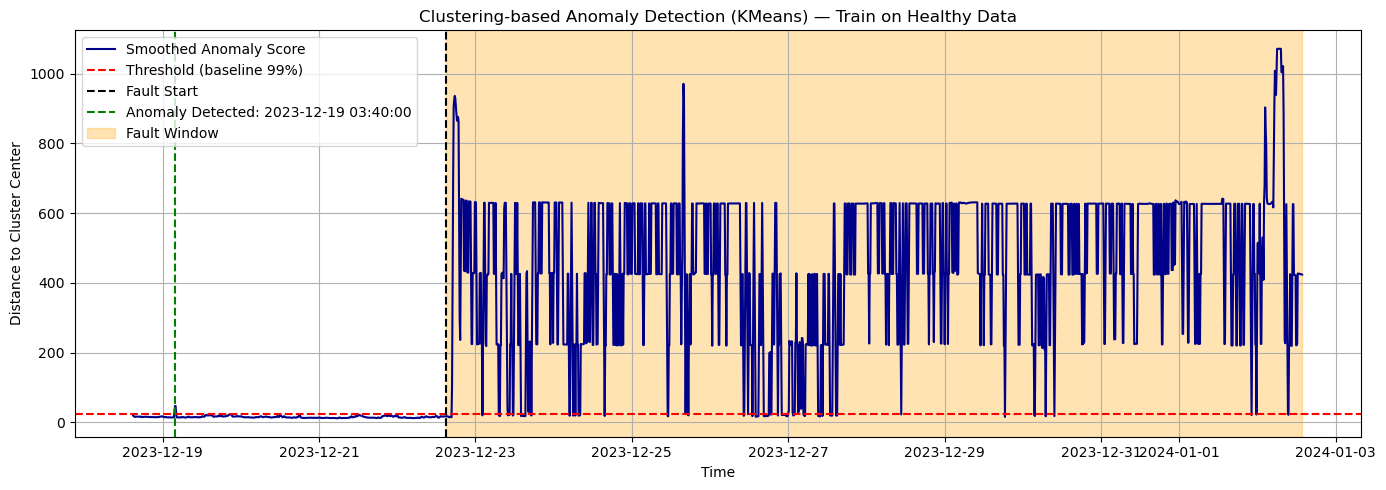

 Anomaly Detected at: 2023-12-19 03:40:00
 Lead Time: 3 days 11:20:00


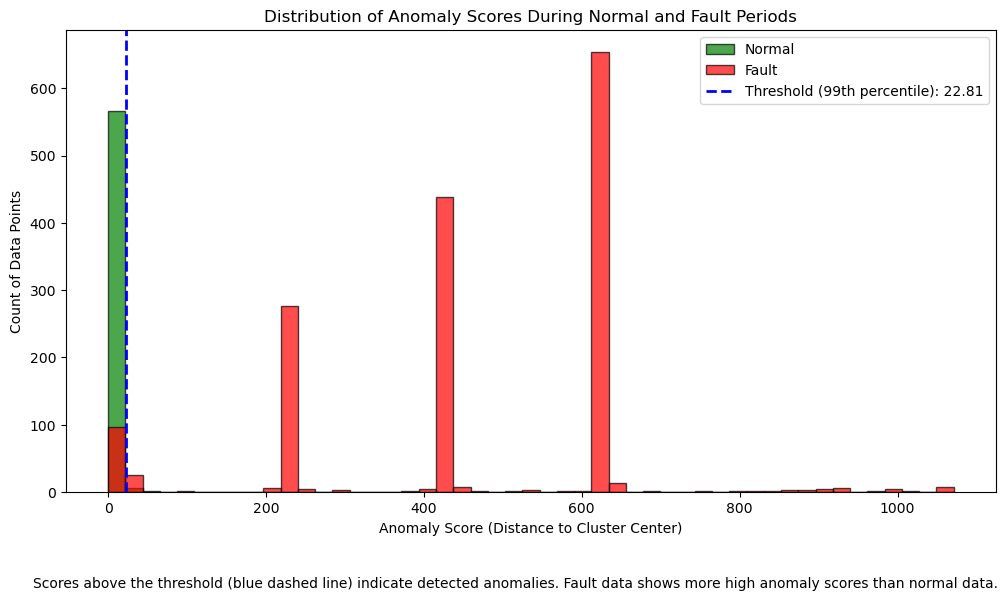

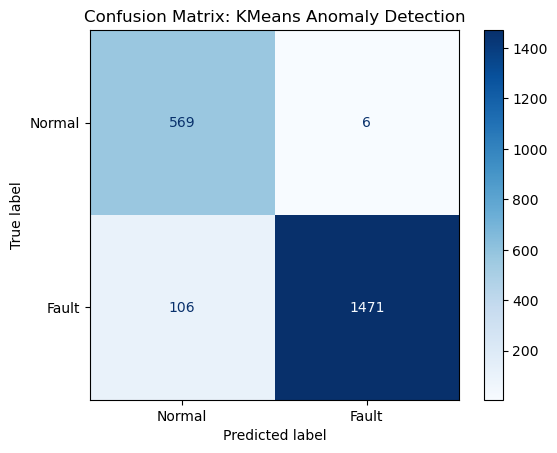


Classification Report:

              precision    recall  f1-score   support

      Normal       0.84      0.99      0.91       575
       Fault       1.00      0.93      0.96      1577

    accuracy                           0.95      2152
   macro avg       0.92      0.96      0.94      2152
weighted avg       0.96      0.95      0.95      2152



In [32]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# --- Prepare train and test sensor data ---


event_start = pd.to_datetime("2023-12-22 15:00:00")
event_end = pd.to_datetime("2024-01-02 13:40:00")
# Select numeric sensor columns (exclude metadata)
drop_cols = ['time_stamp', 'asset_id', 'status_type_id', 'train_test', 'label']

train_sensor_cols = [col for col in df_train_only_sensors.columns if col not in drop_cols]
test_sensor_cols = [col for col in df_test_combined.columns if col not in drop_cols]

# Ensure columns are aligned and present in both
common_sensor_cols = list(set(train_sensor_cols).intersection(set(test_sensor_cols)))

# --- Normalize training data ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df_train_only_sensors[common_sensor_cols].dropna())

# --- Fit KMeans on training data (healthy state) ---
kmeans = KMeans(n_clusters=1, random_state=42)
kmeans.fit(X_train_scaled)

# --- Normalize test data using training scaler ---
X_test_scaled = scaler.transform(df_test_combined[common_sensor_cols].dropna())

# --- Compute anomaly score = distance to cluster center ---
distances = np.linalg.norm(X_test_scaled - kmeans.cluster_centers_, axis=1)

# Align with timestamps of test data points (after dropna)
test_indices = df_test_combined[common_sensor_cols].dropna().index
timestamps = df_test_combined.loc[test_indices, 'time_stamp']

df_anomaly = pd.DataFrame({
    'timestamp': timestamps.values,
    'distance_to_center': distances
}).set_index('timestamp')

# --- Smooth anomaly scores with a slightly larger window (3 points) ---
df_anomaly['smoothed'] = df_anomaly['distance_to_center'].rolling(window=3, min_periods=1).mean()

# ---  Determine threshold from pre-fault baseline period only with lower quantile for earlier detection ---
baseline_anomaly = df_anomaly[df_anomaly.index < event_start]
threshold = baseline_anomaly['smoothed'].quantile(0.99)  

# --- Detect earliest breach exceeding threshold ---
breach_time = df_anomaly[df_anomaly['smoothed'] > threshold].index.min()

# ---  Plot anomaly scores and detection ---
plt.figure(figsize=(14, 5))
plt.plot(df_anomaly.index, df_anomaly['smoothed'], label='Smoothed Anomaly Score', color='darkblue')
plt.axhline(threshold, linestyle='--', color='red', label='Threshold (baseline 99%)')
plt.axvline(event_start, color='black', linestyle='--', label='Fault Start')
if breach_time:
    plt.axvline(breach_time, color='green', linestyle='--', label=f'Anomaly Detected: {breach_time}')
plt.axvspan(event_start, event_end, color='orange', alpha=0.3, label='Fault Window')
plt.title("Clustering-based Anomaly Detection (KMeans) — Train on Healthy Data")
plt.xlabel("Time")
plt.ylabel("Distance to Cluster Center")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Calculate lead time ---
if breach_time:
    lead_time = event_start - breach_time
    print(f" Anomaly Detected at: {breach_time}")
    print(f" Lead Time: {lead_time}")
else:
    print(" No anomaly detected before fault.")

# --- Additional: Plot histogram of anomaly scores for fault vs normal periods ---
plt.figure(figsize=(12, 6))

# Grouped histogram with bins and alpha for transparency
bins = np.linspace(0, df_anomaly['smoothed'].max(), 50)

plt.hist(df_anomaly[df_anomaly.index < event_start]['smoothed'], bins=bins, alpha=0.7, label='Normal', color='green', edgecolor='black')
plt.hist(df_anomaly[(df_anomaly.index >= event_start) & (df_anomaly.index <= event_end)]['smoothed'], bins=bins, alpha=0.7, label='Fault', color='red', edgecolor='black')

# Threshold line
plt.axvline(threshold, color='blue', linestyle='--', linewidth=2, label=f'Threshold (99th percentile): {threshold:.2f}')

plt.title("Distribution of Anomaly Scores During Normal and Fault Periods")
plt.xlabel("Anomaly Score (Distance to Cluster Center)")
plt.ylabel("Count of Data Points")
plt.legend()

# Caption below the plot
plt.figtext(0.5, -0.05, "Scores above the threshold (blue dashed line) indicate detected anomalies. Fault data shows more high anomaly scores than normal data.", ha="center", fontsize=10)

plt.show()


# Add fault labels to df_anomaly for evaluation ---
df_anomaly['fault'] = (df_anomaly.index >= event_start) & (df_anomaly.index <= event_end)

# Predicted label based on threshold
df_anomaly['predicted_fault'] = df_anomaly['smoothed'] > threshold

# Confusion matrix & classification report ---
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Ground truth and predictions
y_true = df_anomaly['fault']
y_pred = df_anomaly['predicted_fault']

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = ['Normal', 'Fault']

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix: KMeans Anomaly Detection")
plt.grid(False)
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))



In [33]:
import pandas as pd

# 1. Load event info
event_info = pd.read_csv('/home/bcae/ML_Cleaned_with_sensors/event_info.csv', sep = ";", parse_dates=['event_start', 'event_end'])

# 2. Filter for asset_id == 21 and label == 'normal'
normal_events = event_info[
    (event_info['asset_id'] == 21) &
    (event_info['event_label'].str.lower() == 'normal')
]

print("Found normal intervals:\n", normal_events[['event_start', 'event_end']])

# 3. Load the corresponding turbine SCADA file — e.g., 21.csv
scada_21 = pd.read_csv('datasets/62.csv', sep=';', parse_dates=['time_stamp'])

# 4. Filter SCADA data for normal periods
baseline_normal_df = pd.DataFrame()

for _, row in normal_events.iterrows():
    mask = (scada_21['time_stamp'] >= row['event_start']) & (scada_21['time_stamp'] <= row['event_end'])
    baseline_normal_df = pd.concat([baseline_normal_df, scada_21[mask]])

# 5. Optional: Reset index and confirm shape
baseline_normal_df.reset_index(drop=True, inplace=True)
print(f" Baseline data shape: {baseline_normal_df.shape}")


Found normal intervals:
            event_start           event_end
30 2023-11-06 11:00:00 2023-11-13 14:50:00


/tmp/ipykernel_1417293/1993867786.py:4: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  event_info = pd.read_csv('/home/bcae/ML_Cleaned_with_sensors/event_info.csv', sep = ";", parse_dates=['event_start', 'event_end'])
/tmp/ipykernel_1417293/1993867786.py:4: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  event_info = pd.read_csv('/home/bcae/ML_Cleaned_with_sensors/event_info.csv', sep = ";", parse_dates=['event_start', 'event_end'])


 Baseline data shape: (1032, 957)


In [34]:
# Define columns to drop (metadata, non-sensor)
drop_cols = ['id','time_stamp', 'asset_id', 'status_type_id', 'train_test', 'label']

# Get sensor columns from training and test data
train_sensor_cols = [col for col in df_train_only_sensors.columns if col not in drop_cols]
test_sensor_cols = [col for col in df_test_combined.columns if col not in drop_cols]

# Find the intersection of columns across train, test, and baseline normal data
common_sensor_cols = list(
    set(train_sensor_cols)
    .intersection(set(test_sensor_cols))
    .intersection(set(baseline_normal_df.columns))
)

# Filter baseline_normal_df to keep only these common sensor columns plus timestamp (if needed)
baseline_normal_df_sync = baseline_normal_df[['time_stamp'] + common_sensor_cols].copy()

print(f" Baseline normal data synced columns shape: {baseline_normal_df_sync.shape}")
print(f"Columns:\n{baseline_normal_df_sync.columns.tolist()}")


 Baseline normal data synced columns shape: (1032, 274)
Columns:
['time_stamp', 'sensor_76_min', 'sensor_110_min', 'sensor_224_avg', 'sensor_9_max', 'sensor_69_min', 'sensor_150_std', 'sensor_190_avg', 'sensor_113_std', 'sensor_78_std', 'sensor_205_std', 'sensor_25_std', 'sensor_42_avg', 'sensor_11_avg', 'sensor_9_avg', 'sensor_83_avg', 'sensor_45_min', 'sensor_44_max', 'wind_speed_237_std', 'sensor_151_std', 'sensor_59_max', 'sensor_55_std', 'sensor_9_std', 'sensor_139_std', 'sensor_109_max', 'sensor_212_std', 'sensor_87_avg', 'sensor_185_std', 'sensor_177_std', 'sensor_170_std', 'sensor_114_avg', 'sensor_89_std', 'sensor_37_max', 'sensor_109_min', 'sensor_116_avg', 'sensor_46_avg', 'sensor_126_max', 'sensor_1_avg', 'sensor_26_avg', 'sensor_123_max', 'sensor_52_max', 'sensor_124_max', 'sensor_176_std', 'sensor_193_std', 'sensor_74_avg', 'sensor_51_max', 'sensor_113_max', 'reactive_power_119_std', 'sensor_46_std', 'sensor_43_max', 'sensor_84_std', 'sensor_227_max', 'sensor_227_min', 's

In [35]:
df_train_only_sensors.shape

(40803, 274)

In [36]:
# Columns used during training/scaler fitting
print("Columns used during training:")
print(common_sensor_cols)

# Columns present in baseline data
print("\nColumns in baseline data:")
print(list(baseline_normal_df.columns))

# Find columns in training but missing in baseline
missing_in_baseline = [col for col in common_sensor_cols if col not in baseline_normal_df.columns]
print("\nColumns missing in baseline data:")
print(missing_in_baseline)

# Find columns in baseline but not in training
extra_in_baseline = [col for col in baseline_normal_df.columns if col not in common_sensor_cols]
print("\nExtra columns in baseline data:")
print(extra_in_baseline)


Columns used during training:
['sensor_76_min', 'sensor_110_min', 'sensor_224_avg', 'sensor_9_max', 'sensor_69_min', 'sensor_150_std', 'sensor_190_avg', 'sensor_113_std', 'sensor_78_std', 'sensor_205_std', 'sensor_25_std', 'sensor_42_avg', 'sensor_11_avg', 'sensor_9_avg', 'sensor_83_avg', 'sensor_45_min', 'sensor_44_max', 'wind_speed_237_std', 'sensor_151_std', 'sensor_59_max', 'sensor_55_std', 'sensor_9_std', 'sensor_139_std', 'sensor_109_max', 'sensor_212_std', 'sensor_87_avg', 'sensor_185_std', 'sensor_177_std', 'sensor_170_std', 'sensor_114_avg', 'sensor_89_std', 'sensor_37_max', 'sensor_109_min', 'sensor_116_avg', 'sensor_46_avg', 'sensor_126_max', 'sensor_1_avg', 'sensor_26_avg', 'sensor_123_max', 'sensor_52_max', 'sensor_124_max', 'sensor_176_std', 'sensor_193_std', 'sensor_74_avg', 'sensor_51_max', 'sensor_113_max', 'reactive_power_119_std', 'sensor_46_std', 'sensor_43_max', 'sensor_84_std', 'sensor_227_max', 'sensor_227_min', 'sensor_94_std', 'sensor_8_std', 'sensor_1_std', 's

In [37]:
# Select columns from baseline dataset that your model expects
baseline_features_aligned = baseline_normal_df[common_sensor_cols]

# Check if any columns are missing in baseline (should be none if filtered above)
missing_cols = [col for col in common_sensor_cols if col not in baseline_normal_df.columns]
print("Missing columns in baseline data:", missing_cols)


Missing columns in baseline data: []


In [38]:
extra_columns = set(baseline_normal_df.columns) - set(common_sensor_cols)
print("Extra columns in baseline data:", extra_columns)


Extra columns in baseline data: {'sensor_100_std', 'sensor_138_max', 'sensor_184_min', 'sensor_40_min', 'sensor_27_std', 'sensor_205_max', 'sensor_221_min', 'sensor_128_avg', 'sensor_128_max', 'sensor_159_avg', 'sensor_148_std', 'sensor_89_min', 'sensor_29_max', 'reactive_power_119_avg', 'wind_speed_236_max', 'sensor_19_std', 'sensor_143_min', 'sensor_186_min', 'sensor_231_std', 'sensor_15_min', 'sensor_174_max', 'id', 'sensor_29_min', 'sensor_134_min', 'sensor_36_std', 'asset_id', 'sensor_161_avg', 'sensor_221_avg', 'sensor_30_max', 'sensor_228_min', 'sensor_22_min', 'sensor_66_std', 'sensor_81_min', 'sensor_92_min', 'sensor_156_std', 'sensor_98_std', 'sensor_4_min', 'sensor_193_avg', 'sensor_135_std', 'power_5_std', 'sensor_8_max', 'power_6_avg', 'sensor_47_max', 'sensor_176_max', 'sensor_50_max', 'sensor_155_max', 'sensor_48_std', 'sensor_221_max', 'sensor_232_std', 'sensor_143_avg', 'sensor_90_min', 'sensor_200_std', 'sensor_169_min', 'sensor_78_avg', 'sensor_115_min', 'sensor_97_m

In [39]:
baseline_normal_df = baseline_normal_df.drop(columns=list(extra_columns))


/opt/miniconda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


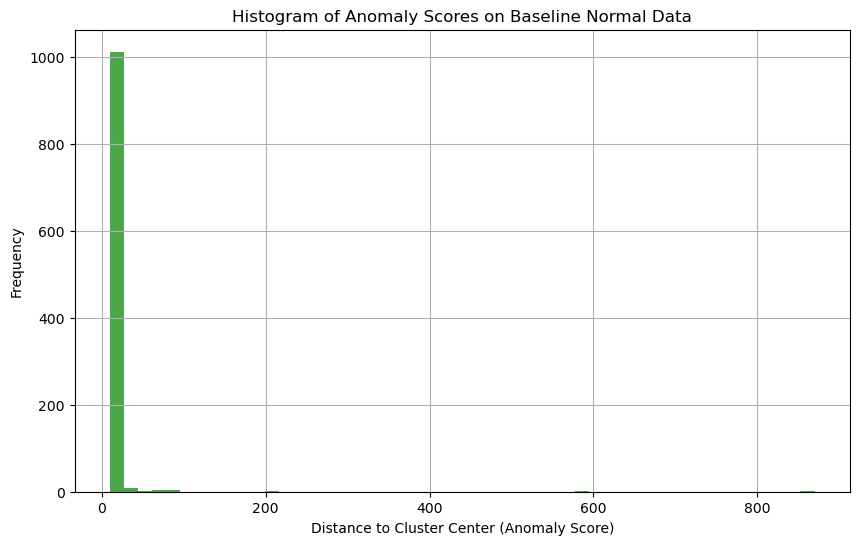

Threshold (99th percentile) on baseline data: 41.1486
False positives detected: 11 out of 1032 samples
False positive rate: 1.0659%


In [40]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt



# 1. Ensure baseline_normal_df has exactly the same columns (features) as training data used in clustering
common_sensor_cols = [col for col in df_train_only_sensors.columns if col not in ['time_stamp', 'asset_id', 'status_type_id', 'train_test', 'label']]

# Drop any extra columns from baseline
extra_columns = set(baseline_normal_df.columns) - set(common_sensor_cols)
if extra_columns:
    baseline_normal_df = baseline_normal_df.drop(columns=list(extra_columns))

# Add missing columns with zeros if any
missing_columns = set(common_sensor_cols) - set(baseline_normal_df.columns)
for col in missing_columns:
    baseline_normal_df[col] = 0

# Reorder columns to match training data
baseline_normal_df = baseline_normal_df[common_sensor_cols]

# Drop any rows with NaN values if any remain
baseline_normal_df = baseline_normal_df.dropna()

# 2. Normalize training data and baseline data using the same scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df_train_only_sensors[common_sensor_cols].dropna())
X_baseline_scaled = scaler.transform(baseline_normal_df)

# 3. Fit KMeans on training data (healthy state)
kmeans = KMeans(n_clusters=1, random_state=42)
kmeans.fit(X_train_scaled)

# 4. Calculate anomaly scores on baseline normal data (should be mostly low)
distances_baseline = np.linalg.norm(X_baseline_scaled - kmeans.cluster_centers_, axis=1)

# 5. Analyze anomaly scores on baseline data
plt.figure(figsize=(10, 6))
plt.hist(distances_baseline, bins=50, color='green', alpha=0.7)
plt.title('Histogram of Anomaly Scores on Baseline Normal Data')
plt.xlabel('Distance to Cluster Center (Anomaly Score)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 6. Optional: Calculate threshold from training data (e.g., 95th percentile) and count false positives
threshold = np.percentile(distances_baseline, 99)
false_positives = np.sum(distances_baseline > threshold)
total_samples = len(distances_baseline)
print(f"Threshold (99th percentile) on baseline data: {threshold:.4f}")
print(f"False positives detected: {false_positives} out of {total_samples} samples")
print(f"False positive rate: {false_positives / total_samples:.4%}")


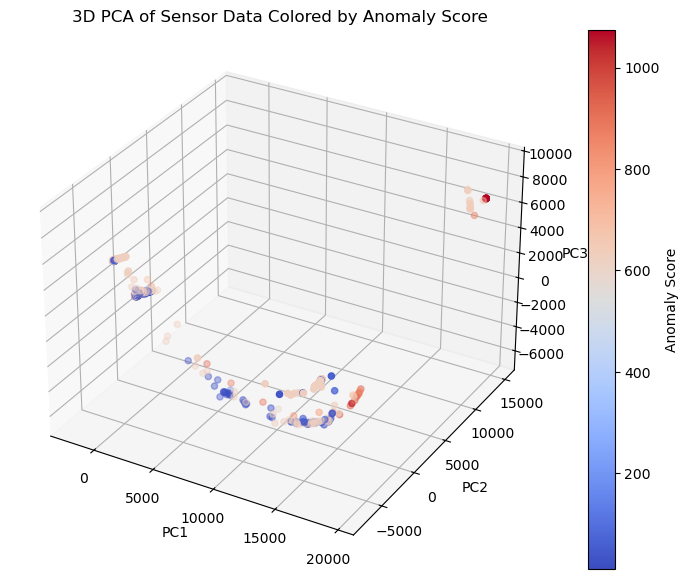

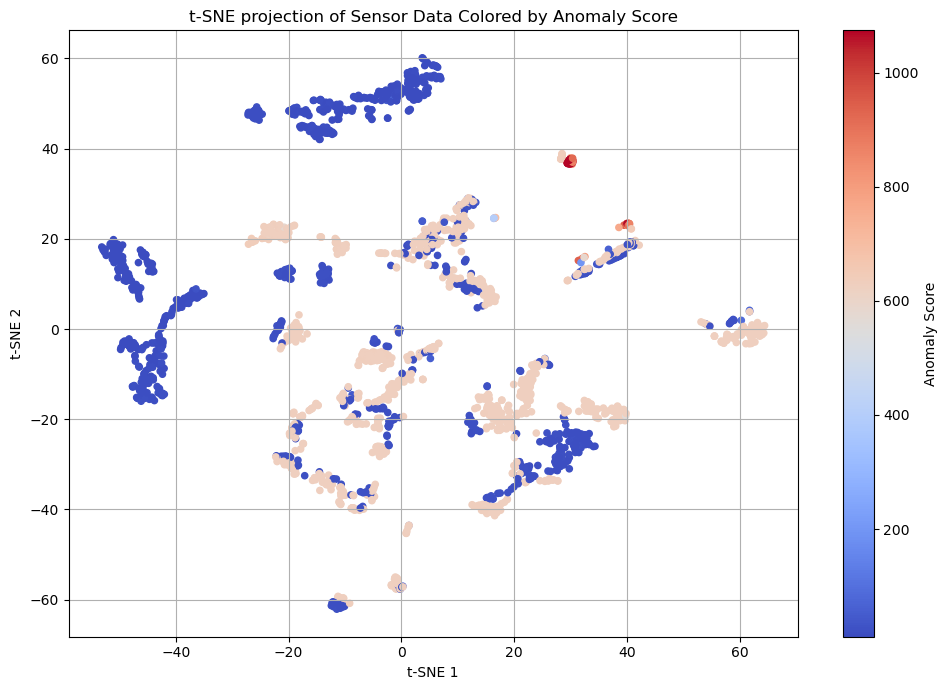

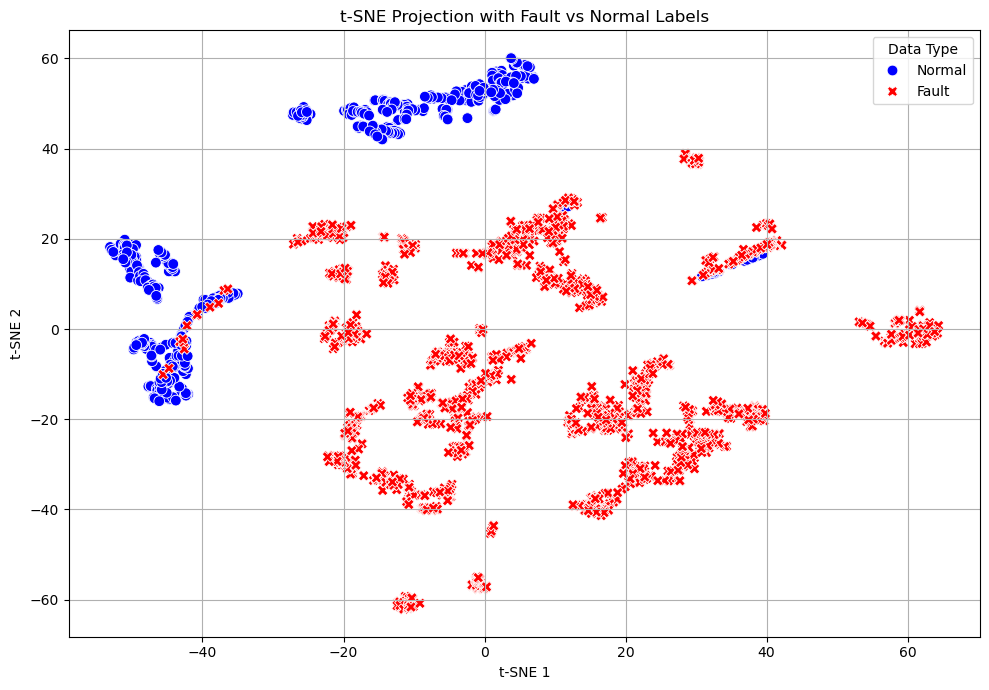

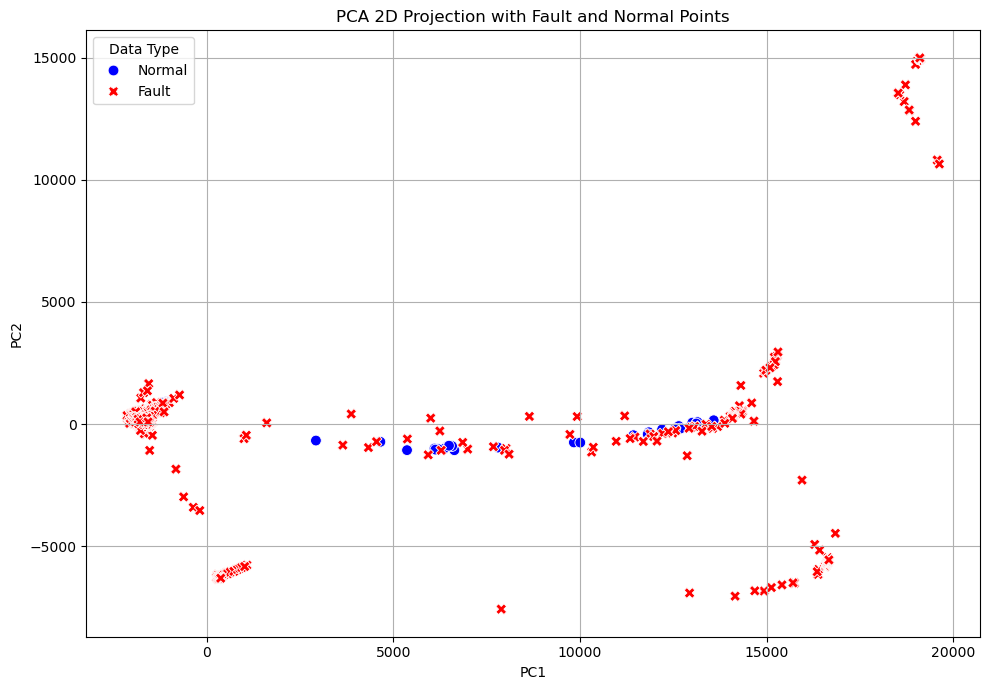

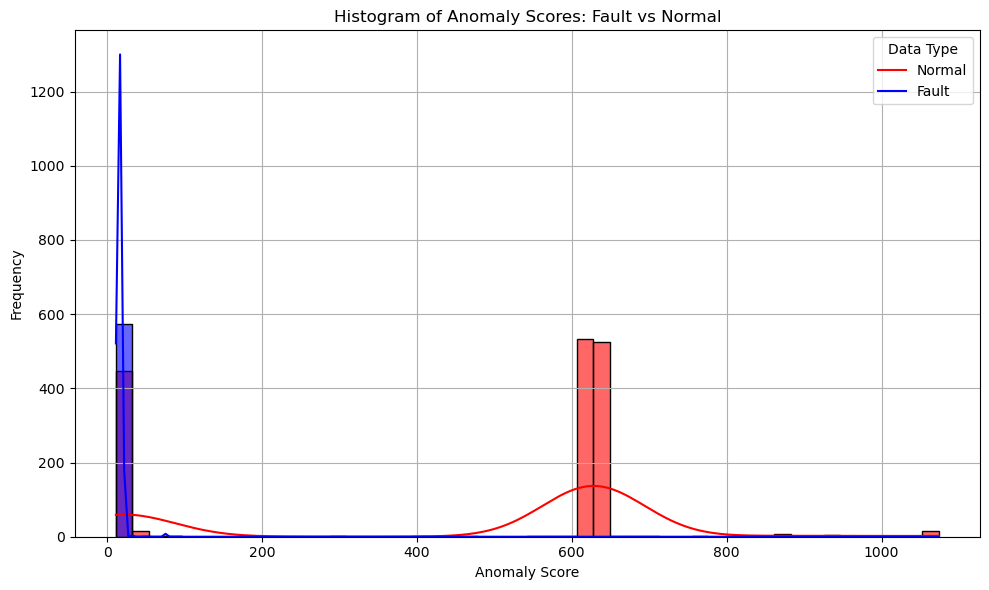

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Prepare data with anomaly score and fault label
df_vis = df_test_combined.loc[test_indices].copy()
df_vis['anomaly_score'] = df_anomaly['distance_to_center'].values
df_vis['fault'] = ((df_vis['time_stamp'] >= event_start) & (df_vis['time_stamp'] <= event_end))

# ---------------- 1. 3D PCA Colored by Anomaly Score ----------------
pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(df_test_combined[common_sensor_cols].loc[test_indices])

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(
    pca_result_3d[:, 0], pca_result_3d[:, 1], pca_result_3d[:, 2],
    c=df_vis['anomaly_score'], cmap='coolwarm', s=20
)
fig.colorbar(p, label='Anomaly Score')
ax.set_title('3D PCA of Sensor Data Colored by Anomaly Score')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

# ---------------- 2. t-SNE Colored by Anomaly Score ----------------
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(df_test_combined[common_sensor_cols].loc[test_indices])

plt.figure(figsize=(10, 7))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=df_vis['anomaly_score'], cmap='coolwarm', s=20)
plt.colorbar(scatter, label='Anomaly Score')
plt.title('t-SNE projection of Sensor Data Colored by Anomaly Score')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True)
plt.tight_layout()
plt.show()

# t-SNE With Fault Labels Overlay ----------------
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=tsne_result[:, 0], y=tsne_result[:, 1],
    hue=df_vis['fault'].map({True: 'Fault', False: 'Normal'}),
    style=df_vis['fault'].map({True: 'Fault', False: 'Normal'}),
    palette={'Normal': 'blue', 'Fault': 'red'},
    markers={'Normal': 'o', 'Fault': 'X'},
    s=60
)
plt.title('t-SNE Projection with Fault vs Normal Labels')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Data Type')
plt.grid(True)
plt.tight_layout()
plt.show()

#  2D PCA With Fault Labels Overlay ----------------
pca_2d = PCA(n_components=2)
pca_result_2d = pca_2d.fit_transform(df_test_combined[common_sensor_cols].loc[test_indices])

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=pca_result_2d[:, 0], y=pca_result_2d[:, 1],
    hue=df_vis['fault'].map({True: 'Fault', False: 'Normal'}),
    style=df_vis['fault'].map({True: 'Fault', False: 'Normal'}),
    palette={'Normal': 'blue', 'Fault': 'red'},
    markers={'Normal': 'o', 'Fault': 'X'},
    s=60
)
plt.title('PCA 2D Projection with Fault and Normal Points')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Data Type')
plt.grid(True)
plt.tight_layout()
plt.show()

#  Histogram of Anomaly Scores ----------------
plt.figure(figsize=(10, 6))
sns.histplot(df_vis, x='anomaly_score', hue='fault', bins=50, kde=True,
             palette={True: 'red', False: 'blue'}, alpha=0.6)
plt.title('Histogram of Anomaly Scores: Fault vs Normal')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend(title='Data Type', labels=['Normal', 'Fault'])
plt.grid(True)
plt.tight_layout()
plt.show()


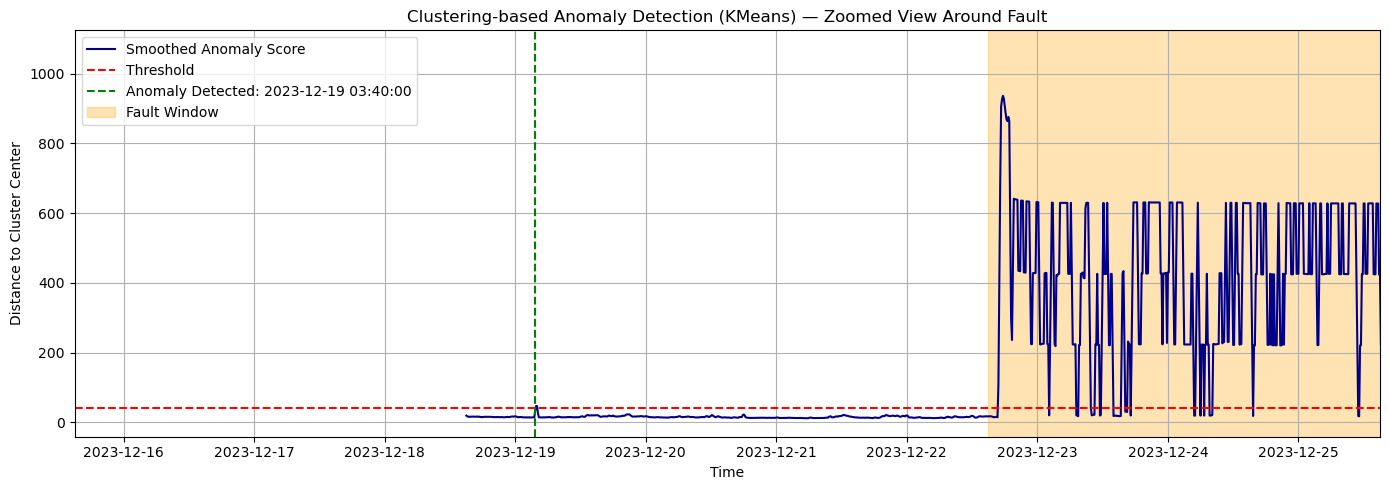

In [42]:
import matplotlib.pyplot as plt
from datetime import timedelta

# 7 days before fault to 3 days after fault
zoom_start = event_start - timedelta(days=7)
zoom_end = event_start + timedelta(days=3)

# Plot anomaly scores with zoomed x-axis
plt.figure(figsize=(14, 5))
plt.plot(df_anomaly.index, df_anomaly['smoothed'], label='Smoothed Anomaly Score', color='darkblue')
plt.axhline(threshold, linestyle='--', color='red', label='Threshold')
if breach_time:
    plt.axvline(breach_time, color='green', linestyle='--', label=f'Anomaly Detected: {breach_time}')
plt.axvspan(event_start, event_end, color='orange', alpha=0.3, label='Fault Window')

plt.xlim(zoom_start, zoom_end)  # Zoom x-axis

plt.title("Clustering-based Anomaly Detection (KMeans) — Zoomed View Around Fault")
plt.xlabel("Time")
plt.ylabel("Distance to Cluster Center")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
